In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas, re

data = pandas.read_csv("/content/drive/Othercomputers/내 노트북/File/spamVenv/files/spam.csv", encoding="UTF-8").dropna(axis=0)

originData = data[["Subject", "Spam/Ham"]].rename(columns={"Spam/Ham":"isSpam", "Subject":"content"}).drop_duplicates() #제목, 스팸여부 & 중복제거(결측치)
originData["isSpam"] = originData['isSpam'].replace(["ham", "spam"], [0, 1]) #범주형 -> 수치형
# data["isSpam"].value_counts() #스팸 비율
# print(f'스팸 : 정상 비율 : {data["isSpam"].value_counts()[0]/data["isSpam"].size} : {data["isSpam"].value_counts()[1]/data["isSpam"].size}')

_index = originData['content'].apply(lambda x: isinstance(x, (int, float))).index[originData['content'].apply(lambda x: isinstance(x, (int, float)))]
originData = originData.drop(_index)
originData['content'].apply(lambda x: isinstance(x, (int, float))).sum()


originData

,content,isSpam
1,"vastar resources , inc .",0
2,calpine daily gas nomination,0
3,re : issue,0
4,meter 7268 nov allocation,0
5,mcmullen gas for 11 / 99,0
...,...,...
33706,= ? iso - 8859 - 2 ? q ? my _ proposition ? =,1
33707,make big bucks in the medical field bait - exc...,1
33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,1
33712,all prescript medicines are on special . to be...,1


In [14]:
from sklearn.model_selection import train_test_split

Xdata = originData["content"]
Ydata = originData["isSpam"]

datas = []
for i in range(5, 100, 5):
    dataRatio  = round(i/100,2)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=dataRatio, random_state=123, stratify=Ydata)
    datas.append({"ratio":dataRatio, "Xdata":Xdata , "Xtrain":Xtrain, "Xtest":Xtest, "Ytrain":Ytrain, "Ytest":Ytest})





In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import mean
for index, data in enumerate(datas):
    Xdata = data["Xdata"]
    Xtrain = data["Xtrain"]
    Xtest = data["Xtest"]
    tokenizer = Tokenizer() #토큰화 진행
    tokenizer.fit_on_texts(Xdata) #각 단어를 숫자와 매핑시키는 집합 생성

    meanLen = round(mean([len(i) for i in Xdata])) #문장의 길이를 통일하기 위해 문장의 길이 평균값

    encodedXtrain = tokenizer.texts_to_sequences(Xtrain) #각 문장의 단어들을 위 집합을 기반으로 [abc, cba] -> [3,39] 와 같이 변경 : encoding된 느낌
    finalXtrain = pad_sequences(encodedXtrain, maxlen=meanLen, padding='post') #입력 데이터 최종본 : 위에서 숫자로 이루어진 문장을 모두 같은 길이의 문장으로 만들어줌(0으로 채워넣는 pad sequence)

    encodedXtest = tokenizer.texts_to_sequences(Xtest)
    finalXtest = pad_sequences(encodedXtest, maxlen=meanLen, padding='post')

    datas[index]["Xtrain"] = finalXtrain
    datas[index]["Xtest"] = finalXtest
    datas[index]["tokenizer"] = tokenizer
    datas[index]["meanLen"] = meanLen
# Xtrain.iloc[0], encodedXtrain[0], finalXtrain[0], print(f'문장의 길이 평균값 : {meanLen}')


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, SimpleRNN
for index, data in enumerate(datas):
    tokenizer = data["tokenizer"]
    meanLen = data["meanLen"]
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1, 32)) #Embedding(단어 집합 길이 + 1, 출력 차원, 입력 최대 길이) -> 입력층
    model.add(SimpleRNN(32))
    # model.add(Flatten()) #다차원을 1차원으로 바꾸어 Dense에 들어갈 수 있도록 변환
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation="sigmoid")) #sigmoid함수를 활성화 함수로 하는 Dense, 출력 1개 -> 출력층
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    datas[index]["model"] = model


In [17]:
import time
for index, data in enumerate(datas):
    model = data["model"]
    Xtrain = data["Xtrain"]
    Ytrain = data["Ytrain"]
    startTime = time.time()
    model.fit(Xtrain, Ytrain, epochs=1, batch_size=100) # 전체 데이터를 2번, 32개씩 풀고 채점
    endTime = time.time()
    datas[index]["time"] = endTime - startTime
# print(f'걸린 시간 : {endTime - startTime}초')

229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7049 - loss: 0.5396
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7387 - loss: 0.4995
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7522 - loss: 0.4924
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7274 - loss: 0.5025
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7512 - loss: 0.4913
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7121 - loss: 0.5389
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7080 - loss: 0.5322
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7126 - loss: 0.5293
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7466 - loss: 0.5029
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6912 - loss: 0.5642
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6875 - loss: 0.5645
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6777 - loss: 0.5719
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7076 - loss: 0.5606
73/73 ━━━━━━━━━━

In [18]:
#모델을 평가하기 위해 test데이터를 전처리 하는 과정(encoding, pad ...)
results = []
for index, data in enumerate(datas):
    model = data["model"]
    Xtest = data["Xtest"]
    Ytest = data["Ytest"]
    loss, accuracy = model.evaluate(Xtest, Ytest, batch_size = 100)
    datas[index]["loss"] = loss
    datas[index]["accuracy"] = accuracy
    results.append({"ratio":data["ratio"], "loss":loss, "accuracy":accuracy, "time":data["time"]})
# print(f'정확도 : {accuracy*100}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8554 - loss: 0.3371  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9031 - loss: 0.2359
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8966 - loss: 0.2624
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8981 - loss: 0.2628
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8925 - loss: 0.2901
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8650 - loss: 0.3419
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8988 - loss: 0.2512
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8912 - loss: 0.2749
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8940 - loss: 0.2740
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8178 - loss: 0.4384
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8662 - loss: 0.3379
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8702 - loss: 0.3258
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8778 - loss: 0.3164
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

In [19]:
for data in datas:
    Ytrain = data["Ytrain"]
    Ytest = data["Ytest"]
    print(f"{data['ratio']}의 정확도 : {data['accuracy']*100}%")
    print(f'훈련데이터 정상 메일 = {round(Ytrain.value_counts()[0]/len(Ytrain) * 100)}%')
    print(f'훈련데이터 스팸 메일 = {round(Ytrain.value_counts()[1]/len(Ytrain) * 100)}%')
    print(f'총 훈련데이터 수 : {Ydata.size}개 중 {Ytrain.size}개, {round(Ytrain.size/Ydata.size*100)}%')
    print(f'테스트데이터 정상 메일 = {round(Ytest.value_counts()[0]/len(Ytest) * 100)}%')
    print(f'테스트데이터 스팸 메일 = {round(Ytest.value_counts()[1]/len(Ytest) * 100)}%')
    print(f'총 테스트데이터 수 : {Ydata.size}개 중 {Ytest.size}개, {round(Ytest.size/Ydata.size*100)}%')
    print()
    # print(f'뽑은 데이터 비율 = {round(Ydata.size/data["isSpam"].size * 100)}%, 총 {data["isSpam"].size}개 중 {Ydata.size}개 선별.')


0.05의 정확도 : 85.4288101196289%
훈련데이터 정상 메일 = 53%
훈련데이터 스팸 메일 = 47%
총 훈련데이터 수 : 24012개 중 22811개, 95%
테스트데이터 정상 메일 = 53%
테스트데이터 스팸 메일 = 47%
총 테스트데이터 수 : 24012개 중 1201개, 5%

0.1의 정확도 : 90.2164876461029%
훈련데이터 정상 메일 = 53%
훈련데이터 스팸 메일 = 47%
총 훈련데이터 수 : 24012개 중 21610개, 90%
테스트데이터 정상 메일 = 53%
테스트데이터 스팸 메일 = 47%
총 테스트데이터 수 : 24012개 중 2402개, 10%

0.15의 정확도 : 89.56135511398315%
훈련데이터 정상 메일 = 53%
훈련데이터 스팸 메일 = 47%
총 훈련데이터 수 : 24012개 중 20410개, 85%
테스트데이터 정상 메일 = 53%
테스트데이터 스팸 메일 = 47%
총 테스트데이터 수 : 24012개 중 3602개, 15%

0.2의 정확도 : 90.08952975273132%
훈련데이터 정상 메일 = 53%
훈련데이터 스팸 메일 = 47%
총 훈련데이터 수 : 24012개 중 19209개, 80%
테스트데이터 정상 메일 = 53%
테스트데이터 스팸 메일 = 47%
총 테스트데이터 수 : 24012개 중 4803개, 20%

0.25의 정확도 : 89.02215361595154%
훈련데이터 정상 메일 = 53%
훈련데이터 스팸 메일 = 47%
총 훈련데이터 수 : 24012개 중 18009개, 75%
테스트데이터 정상 메일 = 53%
테스트데이터 스팸 메일 = 47%
총 테스트데이터 수 : 24012개 중 6003개, 25%

0.3의 정확도 : 86.52137517929077%
훈련데이터 정상 메일 = 53%
훈련데이터 스팸 메일 = 47%
총 훈련데이터 수 : 24012개 중 16808개, 70%
테스트데이터 정상 메일 = 53%
테스트데이터 스팸 메일 = 47%
총 테스트데이터

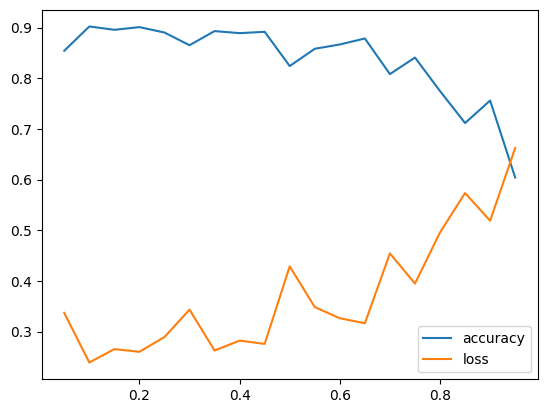

In [20]:
import matplotlib.pyplot as plt

x = [data["ratio"] for data in datas]
y1 = [data["accuracy"] for data in datas]
y2 = [data["loss"] for data in datas]
y3 = [data["time"] for data in datas]

plt.plot(x, y1, label="accuracy")
plt.plot(x, y2, label="loss")
# plt.plot(x, y3, label="time")
plt.legend()
plt.show()